In [24]:
!pip install catboost

In [25]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import xgboost as xgb

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.metrics import log_loss
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [26]:
df = pd.read_csv( "/content/drive/MyDrive/Orga Datos/TP2/Training.csv" )
test = pd.read_csv( "/content/drive/MyDrive/Orga Datos/TP2/Test.csv" )
test

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_171,Product_Name_332,EUR,0.325,USD,0.36761,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_140,Product_Name_241,EUR,0.275,USD,0.31105,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_171,Product_Name_328,EUR,0.325,USD,0.36761,6/1/2019,6/28/2019,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,6/1/2019,6/29/2019,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,16345,EMEA,KSA,1,1,0,0,0,Bureaucratic_Code_4,6/12/2017,Source_3,South Africa,Account_Name_1686,Opportunity_Name_11120,12364,6508,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_1,Non Binding,Delivery_Terms_7,4/26/2019,None,None,None,None,None,None,NaT,5/24/2019,4/26/2019,Person_Name_13,Product_Family_213,Product_Name_447,USD,0.300,USD,0.30000,5/1/2019,5/10/2019,2019 - 5,Q2,2019,NaT,0,USD,124740.0,USD,147750.0,Prod_Category_A_None
2547,15218,Americas,SE America,1,1,0,0,0,Bureaucratic_Code_4,6/8/2018,None,United States,Account_Name_768,Opportunity_Name_9694,12365,6510,Person_Name_38,Person_Name_38,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_4,4/26/2019,None,None,None,None,None,None,N

In [27]:
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = df['Total_Amount']*0.0096
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = df['Total_Amount']*1.17
df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = df['Total_Amount']*0.70
df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = df['Total_Amount']*1.29
df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'
df.drop('Total_Amount_Currency', axis = 1, inplace = True)

In [28]:
test.loc[test['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = test['Total_Amount']*0.0096
test.loc[test['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

test.loc[test['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = test['Total_Amount']*1.17
test.loc[test['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

test.loc[test['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = test['Total_Amount']*0.70
test.loc[test['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

test.loc[test['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = test['Total_Amount']*1.29
test.loc[test['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'
test.drop('Total_Amount_Currency', axis = 1, inplace = True)

In [29]:
df = df[ df['Total_Amount'] > 0 ]
df['Total_Amount'] = np.log(df.Total_Amount)
df['TRF'] = np.log(df.TRF)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
test = test[ test['Total_Amount'] > 0 ]
test['Total_Amount'] = np.log(test.Total_Amount)
test['TRF'] = np.log(test.TRF)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
df = df.rename(columns={'Stage': 'Decision'})
df = df[ (df['Decision'] == 'Closed Won') | (df['Decision'] == 'Closed Lost') ]
df['Decision'] = np.where(df['Decision'] == 'Closed Won',1,0)
df.dropna(inplace=True)

In [32]:

def dateToNum(x):
  return x.dt.day + x.dt.month*100 + x.dt.year*10000

In [ ]:
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'], errors='coerce')
df['Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'], errors='coerce')
df['Account_Created_Date'] = pd.to_datetime(df['Account_Created_Date'], errors='coerce')
df['Dates_diference'] = dateToNum(df['Planned_Delivery_End_Date']) - dateToNum(df['Planned_Delivery_Start_Date']) # Mejora la prediccion
df.loc[ df['Dates_diference'].isnull() ,('Dates_diference')] = 0


short_df = pd.DataFrame()
short_df['Decision'] = df['Decision']

short_df['Dates_diference'] = df['Dates_diference'] # Mejora la prediccion
#short_df['Month_created'] = pd.to_datetime(df['Account_Created_Date'], errors='coerce').dt.month


#short_df['Bureaucratic_Code_0_Approval'] = df['Bureaucratic_Code_0_Approval'] # Mejora MUUY poco


#short_df['Quote_Type'] = np.where(df['Quote_Type'] == 'Non Binding',1,0) # Irrelevante


#short_df['Pricing, Delivery_Terms_Quote_Appr'] = df['Pricing, Delivery_Terms_Quote_Appr'] # Irrelevante


# Como de los otros codigos hay muy poca cantidad comparados con estos dos no nos importan
short_df['Bureaucratic_Code_4'] = np.where(df['Bureaucratic_Code'] == 'Bureaucratic_Code_4',1,0)
short_df['Bureaucratic_Code_5'] = np.where(df['Bureaucratic_Code'] == 'Bureaucratic_Code_5',1,0)


# Opportunity_Type

df["Opportunity_Type"] = np.where(df.groupby('Opportunity_Type')["Opportunity_Type"].transform(len) > 100, df["Opportunity_Type"], "Other")
mean_encoded_Opportunity_Type = df.groupby("Opportunity_Type")["Decision"].mean().to_dict()
short_df["Opportunity_Type"] = df["Opportunity_Type"].map(mean_encoded_Opportunity_Type)


# Account type

# OneHot encoding
# Como de los otros codigos hay muy poca cantidad comparados con estos tres no nos importan
#short_df['Account_Type_2'] = np.where(df['Account_Type'] == 'Account_Type_2',1,0)
#short_df['Account_Type_0'] = np.where(df['Account_Type'] == 'Account_Type_0',1,0)
#short_df['Account_Type_5'] = np.where(df['Account_Type'] == 'Account_Type_5',1,0)

# Mean encoding
df["Account_Type"] = np.where(df.groupby('Account_Type')["Account_Type"].transform(len) > 5, df["Account_Type"], "Other")
mean_encoded_account = df.groupby("Account_Type")["Decision"].mean().to_dict()
short_df["Account_Type"] = df["Account_Type"].map(mean_encoded_account)


# Region

# mean encoding
df["Region"] = np.where(df.groupby('Region')["Region"].transform(len) > 5, df["Region"], "Other")
mean_encoded_region = df.groupby("Region")["Decision"].mean().to_dict()
short_df["Region"] = df["Region"].map(mean_encoded_region)

# OneHot encoding
#short_df['Region_Japon'] = np.where(df['Region'] == 'Japan',1,0)
#short_df['Region_EMEA '] = np.where(df['Region'] == 'EMEA',1,0)
#short_df['Region_Americas'] = np.where(df['Region'] == 'Americas',1,0)
#short_df['Region_Apac'] = np.where(df['Region'] == 'APAC',1,0)
#short_df['Region_Middle_East'] = np.where(df['Region'] == 'Middle East',1,0)


# Opportunity Owner
df["Opportunity_Owner"] = np.where(df.groupby('Opportunity_Owner')["Opportunity_Owner"].transform(len) > 5, df["Opportunity_Owner"], "Other")
mean_encoded_owner = df.groupby("Opportunity_Owner")["Decision"].mean().to_dict()
short_df["Opportunity_Owner"] = df["Opportunity_Owner"].map(mean_encoded_owner)

# Prodcut name
df["Product_Name"] = np.where(df.groupby('Product_Name')["Product_Name"].transform(len) > 5, df["Product_Name"], "Other")
mean_encoded_product = df.groupby("Product_Name")["Decision"].mean().to_dict() # Mean Encoding
dict_product_name = {k: i for i, k in enumerate(df['Product_Name'].unique())} # Label Encoding
short_df["Product_Name"] = df["Product_Name"].map(dict_product_name)


# Entorpece el aprendizaje
#short_df['TRF'] = df['TRF'] # Entorpece el aprendizaje
#short_df['TRF_Above_average'] =  df['TRF'] > df['TRF'].mean()
#short_df['TRF_Above_average'] = np.where(short_df['TRF_Above_average'] == True,1,0)

short_df['Total_Amount'] = df['Total_Amount'] # Es la mejor
#short_df['Total_Amount_Above_average'] =  df['Total_Amount'] > df['Total_Amount'].mean()
#short_df['Total_Amount_Above_average'] = np.where(short_df['Total_Amount_Above_average'] == True,1,0)
#short_df["Expensive"] = np.where(df["Total_Taxable_Amount"] >= 80000, 1, 0)

short_df.dropna(inplace=True)
short_df

In [34]:
short_df.isnull().sum()

Decision                        0
Dates_diference                 0
Bureaucratic_Code_0_Approval    0
Bureaucratic_Code_4             0
Bureaucratic_Code_5             0
Opportunity_Type                0
Account_Type                    0
Region                          0
Opportunity_Owner               0
Product_Name                    0
Total_Amount                    0
dtype: int64

In [76]:
test['Planned_Delivery_Start_Date'] = pd.to_datetime(test['Planned_Delivery_Start_Date'], errors='coerce')
test['Planned_Delivery_End_Date'] = pd.to_datetime(test['Planned_Delivery_End_Date'], errors='coerce')
test['Account_Created_Date'] = pd.to_datetime(test['Account_Created_Date'], errors='coerce')
test['Dates_diference'] = dateToNum(test['Planned_Delivery_End_Date']) - dateToNum(test['Planned_Delivery_Start_Date']) # Mejora la prediccion
test.loc[ test['Dates_diference'].isnull() , ('Dates_diference')] = 0

short_test = pd.DataFrame()
short_test['Dates_diference'] = test['Dates_diference'] # Mejora la prediccion

#short_test['Month_created'] = pd.to_datetime(test['Account_Created_Date'], errors='coerce').dt.month
#short_test['Month_created'] = test['Account_Created_Date'].dt.month


#short_test['Bureaucratic_Code_0_Approval'] = test['Bureaucratic_Code_0_Approval'] # Mejora MUUY poco

#short_test['Pricing, Delivery_Terms_Quote_Appr'] = test['Pricing, Delivery_Terms_Quote_Appr'] # Irrelevante

# Bureaucratic_Code
short_test['Bureaucratic_Code_4'] = np.where(test['Bureaucratic_Code'] == 'Bureaucratic_Code_4',1,0)
short_test['Bureaucratic_Code_5'] = np.where(test['Bureaucratic_Code'] == 'Bureaucratic_Code_5',1,0)


# Opportunity_Type

short_test["Opportunity_Type"] = test["Opportunity_Type"].map(mean_encoded_Opportunity_Type)
short_test.loc[ short_test['Opportunity_Type'].isnull() ,('Opportunity_Type')] = mean_encoded_Opportunity_Type.get('Other')

# Account_Type
short_test["Account_Type"] = test["Account_Type"].map(mean_encoded_account)

# Region 
short_test["Region"] = test["Region"].map(mean_encoded_region)

# Opportunity_Owner
short_test["Opportunity_Owner"] = test["Opportunity_Owner"].map(mean_encoded_owner)
short_test.loc[ short_test['Opportunity_Owner'].isnull() ,('Opportunity_Owner')] = mean_encoded_owner.get('Other')

# Product_Name
short_test["Product_Name"] = test["Product_Name"].map(dict_product_name)
short_test.loc[ short_test['Product_Name'].isnull() ,('Product_Name')] = 0

#short_test['TRF'] = test['TRF'] #Muy probable que sea una caca

# Total_Amount
short_test['Total_Amount'] = test['Total_Amount'] # Es la mejor



In [ ]:
short_test.isnull().sum()


# XGBoost

In [77]:
X = short_df.drop( 'Decision', axis=1 )
y = short_df['Decision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [78]:
#xg_Regressor1 = xgb.XGBRegressor(colsample_bytree= 0.8, gamma= 1.5, learning_rate= 0.01, max_depth= 20, min_child_weight= 1, n_estimators= 200, subsample= 0.8)
xg_Regressor1 = xgb.XGBRegressor(colsample_bytree= 0.8, gamma= 1.5, learning_rate= 0.01, max_depth= 20, min_child_weight= 1, n_estimators= 250, subsample= 0.8)

xg_Regressor1.fit(X_train,y_train)
xgbr = xg_Regressor1.predict(X_test)

[17:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [79]:
loss = log_loss(y_test, xgbr)
print(f"Log loss is {loss}")

Log loss is 0.4037170087102732


In [80]:
xg_Regressor1.score(X_test, y_test)


0.48841323134668446

Text(0.5, 1.0, 'XGBoost Regressor')

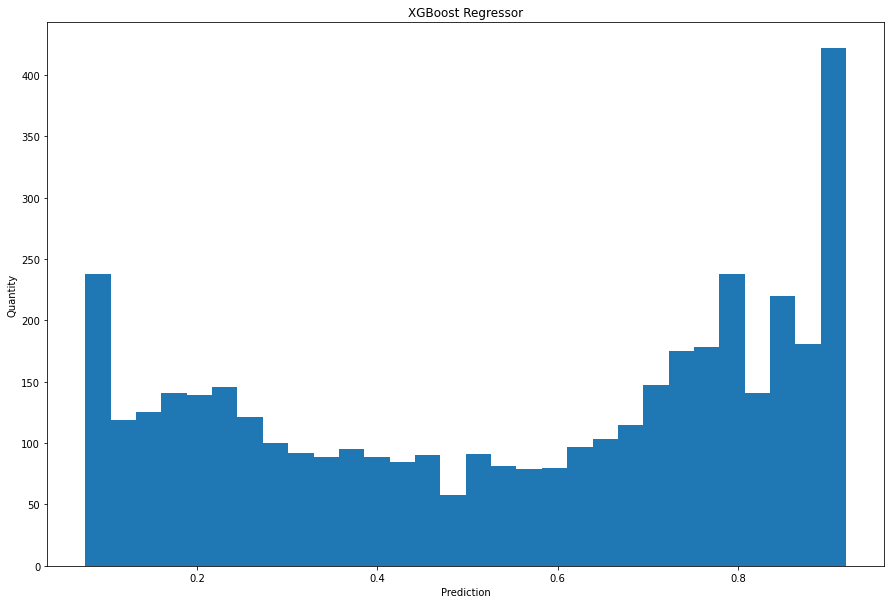

In [41]:
plt.figure(figsize=(15,10))
plt.hist(xgbr, bins=30)
plt.ylabel('Quantity')
plt.xlabel('Prediction')
plt.title('XGBoost Regressor')

['Dates_diference', 'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_4', 'Bureaucratic_Code_5', 'Opportunity_Type', 'Account_Type', 'Region', 'Opportunity_Owner', 'Product_Name', 'Total_Amount']


Text(0.5, 0, 'Relative Importance')

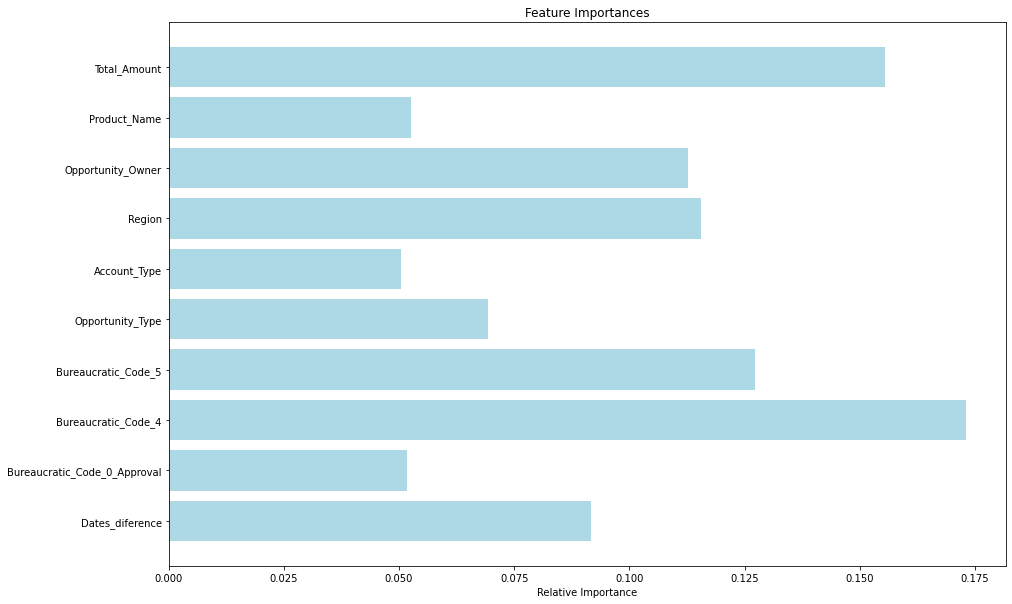

In [42]:
features = X_test.columns.to_list()
importances = xg_Regressor1.feature_importances_
indices = np.argsort(importances)

print(features)


plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(features, importances, color='lightblue', align='center' )
plt.xlabel('Relative Importance')

# CatBoost

In [81]:
#cbr = CatBoostRegressor(learning_rate = 0.0075, verbose = True, random_seed = 123,  num_boost_round = 1500, max_depth = 14)
#cbr = CatBoostRegressor(num_boost_round = 1500, depth= 10, l2_leaf_reg= 20, learning_rate= 0.008)
cbr = CatBoostRegressor(num_boost_round = 1500, learning_rate = 0.008)
cbr.fit(X_train, y_train)
cbr_pred = cbr.predict(X_test)

0:	learn: 0.4958091	total: 3.65ms	remaining: 5.47s
1:	learn: 0.4944709	total: 6.92ms	remaining: 5.18s
2:	learn: 0.4930336	total: 9.76ms	remaining: 4.87s
3:	learn: 0.4916429	total: 12.6ms	remaining: 4.71s
4:	learn: 0.4902959	total: 15.4ms	remaining: 4.6s
5:	learn: 0.4889831	total: 18.2ms	remaining: 4.54s
6:	learn: 0.4876376	total: 20.9ms	remaining: 4.46s
7:	learn: 0.4863709	total: 23.6ms	remaining: 4.39s
8:	learn: 0.4851625	total: 26.2ms	remaining: 4.34s
9:	learn: 0.4838553	total: 30.2ms	remaining: 4.5s
10:	learn: 0.4825974	total: 33ms	remaining: 4.46s
11:	learn: 0.4813313	total: 35.9ms	remaining: 4.45s
12:	learn: 0.4800970	total: 38.6ms	remaining: 4.42s
13:	learn: 0.4788844	total: 41.4ms	remaining: 4.4s
14:	learn: 0.4776977	total: 44.1ms	remaining: 4.37s
15:	learn: 0.4765769	total: 46.9ms	remaining: 4.35s
16:	learn: 0.4754640	total: 49.8ms	remaining: 4.34s
17:	learn: 0.4742127	total: 52.7ms	remaining: 4.33s
18:	learn: 0.4731103	total: 55.4ms	remaining: 4.32s
19:	learn: 0.4719117	total:

In [82]:
loss = log_loss(y_test, cbr_pred)
print(f"Log loss is {loss}")

Log loss is 0.4072589749178916


In [83]:
cbr.score(X_test, y_test)

0.46775579817319335

Text(0.5, 1.0, 'CatBoost Regressor')

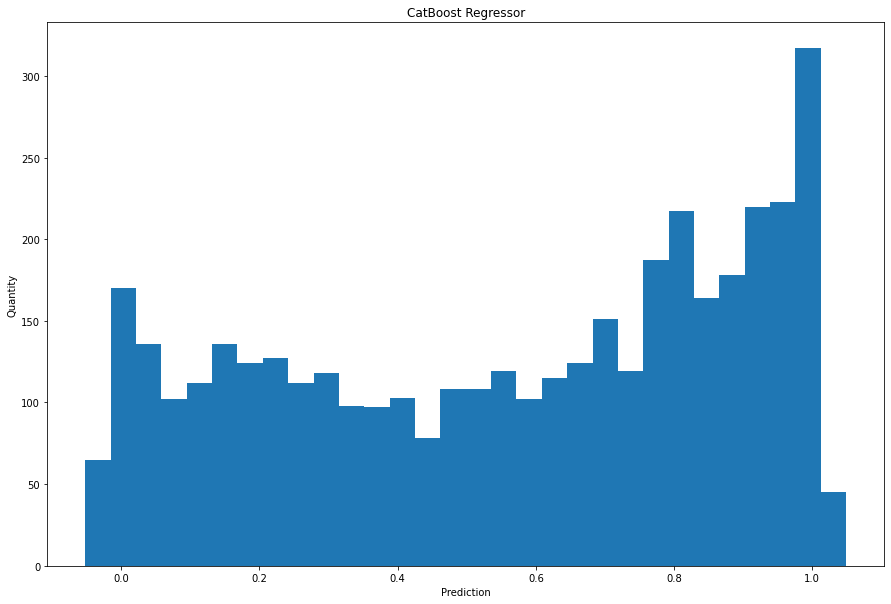

In [46]:
plt.figure(figsize=(15,10))
plt.hist(cbr_pred, bins=30)
plt.ylabel('Quantity')
plt.xlabel('Prediction')
plt.title('CatBoost Regressor')

['Dates_diference', 'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_4', 'Bureaucratic_Code_5', 'Opportunity_Type', 'Account_Type', 'Region', 'Opportunity_Owner', 'Product_Name', 'Total_Amount']


Text(0.5, 0, 'Relative Importance')

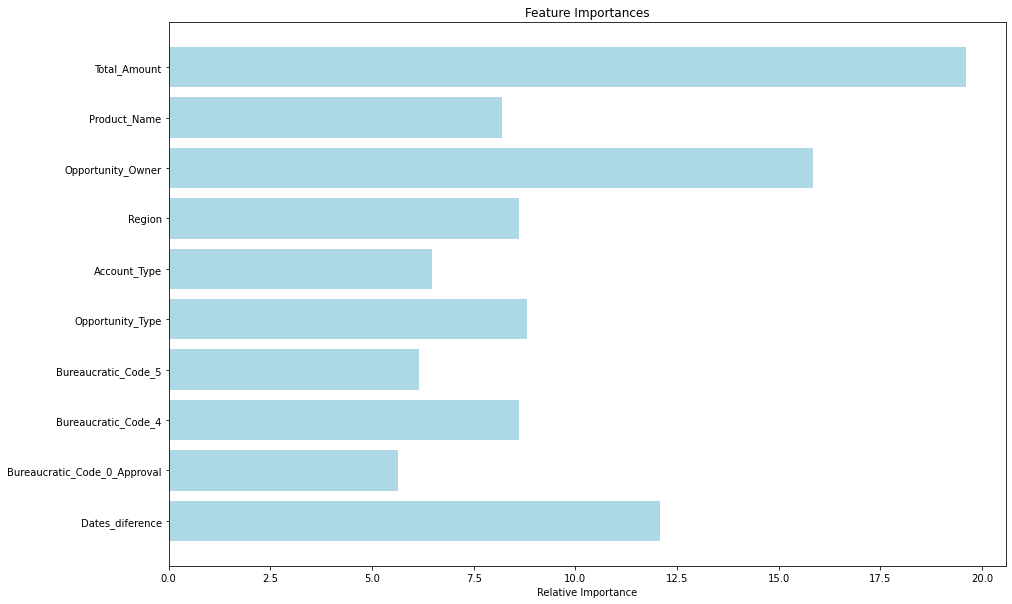

In [47]:
features = X_test.columns.to_list()
importances = cbr.feature_importances_
indices = np.argsort(importances)

print(features)


plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(features, importances, color='lightblue', align='center')
plt.xlabel('Relative Importance')

# LightBM

In [48]:
lbm = LGBMRegressor(boosting_type = "goss", n_estimators = 1500, learning_rate = 0.008, random_state=100)
lbm.fit(X_train, y_train)
lbm_pred = lbm.predict(X_test)


In [49]:
loss = log_loss(y_test, lbm_pred)
print(f"Log loss is {loss}")

Log loss is 7.07530295029891


In [50]:
lbm.score(X_test, y_test)


-7.508844620609395

Text(0.5, 1.0, 'LightGBM Regressor')

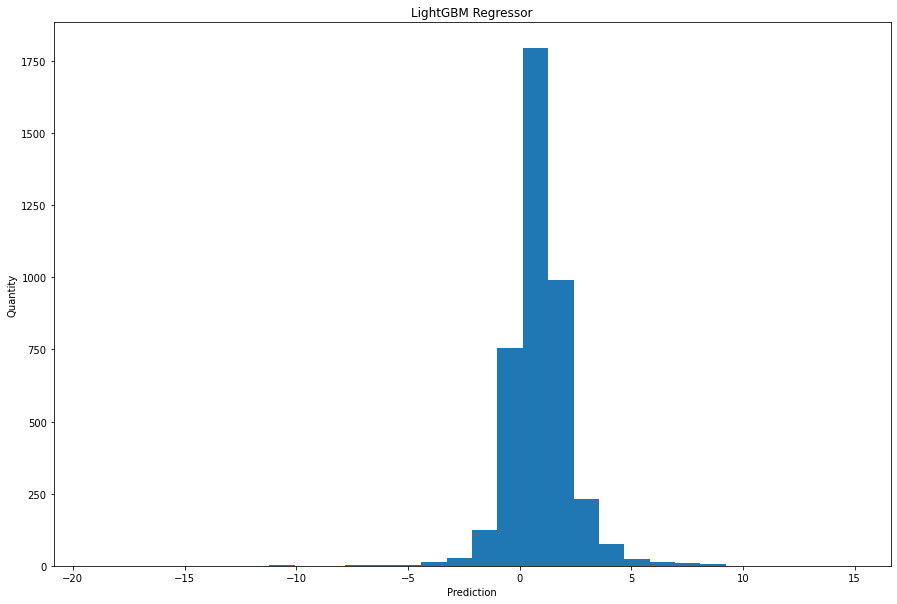

In [51]:
plt.figure(figsize=(15,10))
plt.hist(lbm_pred, bins=30)
plt.ylabel('Quantity')
plt.xlabel('Prediction')
plt.title('LightGBM Regressor')

['Dates_diference', 'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_4', 'Bureaucratic_Code_5', 'Opportunity_Type', 'Account_Type', 'Region', 'Opportunity_Owner', 'Product_Name', 'Total_Amount']


Text(0.5, 0, 'Relative Importance')

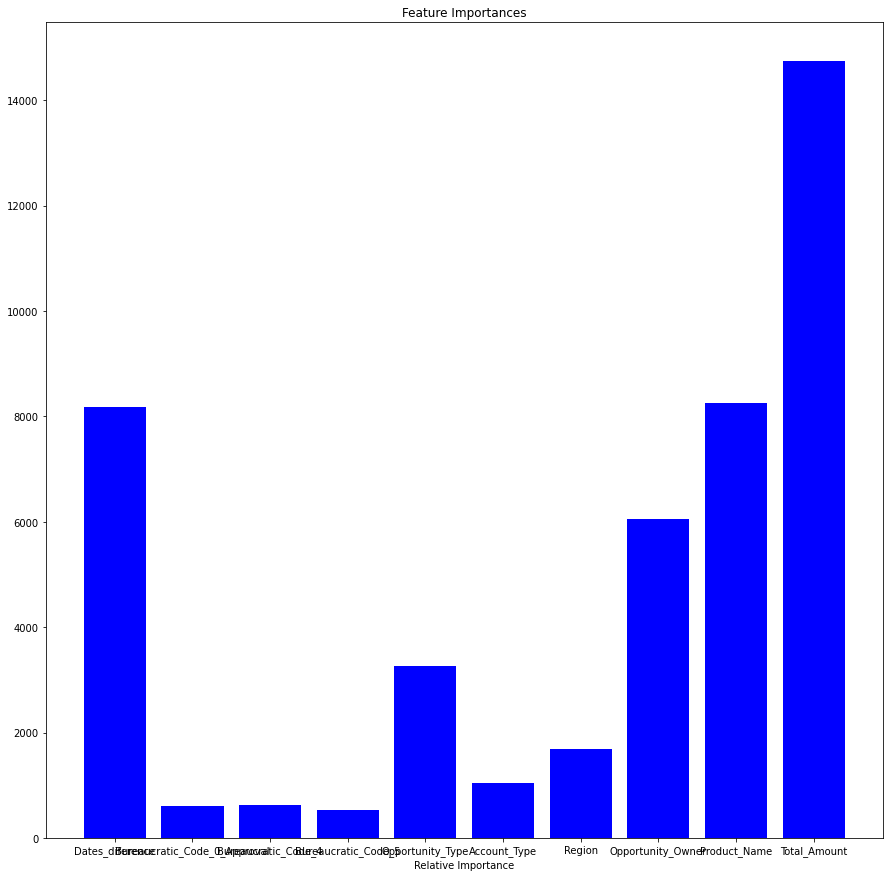

In [52]:
features = X_test.columns.to_list()
importances = lbm.feature_importances_
indices = np.argsort(importances)

print(features)


plt.figure(figsize=(15,15))
plt.title('Feature Importances')
plt.bar(features, importances, color='b', align='center')
plt.xlabel('Relative Importance')

# Voting Regressor

In [ ]:
# , ('lbm', lbm)
ereg = VotingRegressor([ ('xgbr', xg_Regressor1), ('cbr', cbr) ])
ereg.fit(X_train, y_train)
ereg_pred = ereg.predict(X_test)


In [85]:
loss = log_loss(y_test, ereg_pred)
print(f"Log loss is {loss}")

Log loss is 0.40239229812824656


In [86]:
ereg.score(X_test, y_test)


0.48310669942220463

Text(0.5, 1.0, 'Regressor predictions and their average')

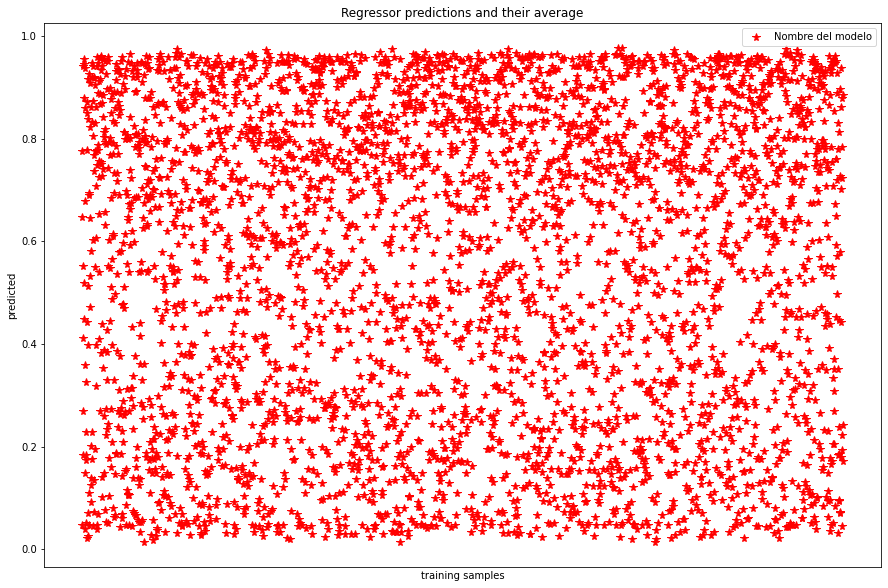

In [56]:
plt.figure(figsize=(15,10))

plt.plot(ereg_pred, 'r*', ms=8,label='Nombre del modelo')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')


Text(0.5, 1.0, 'Voting Regressor')

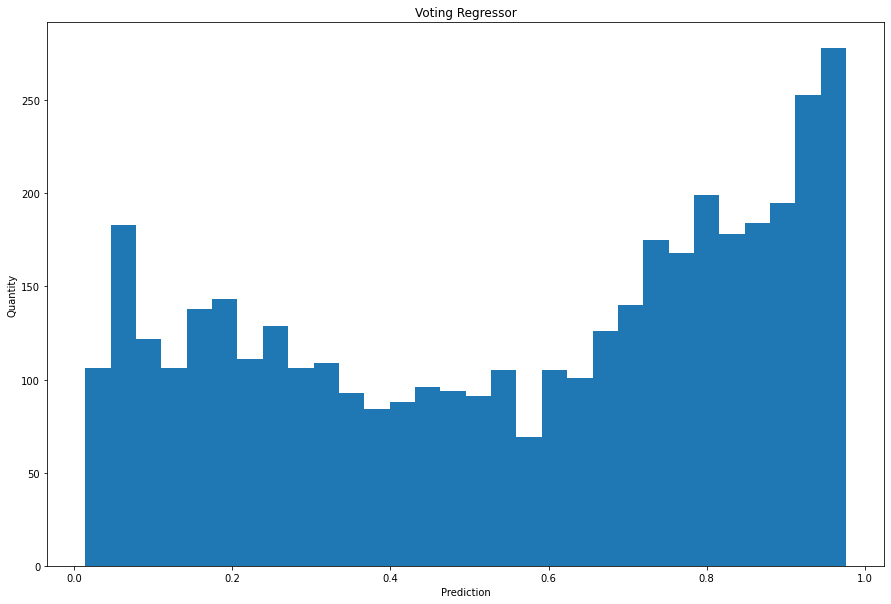

In [57]:
plt.figure(figsize=(15,10))
plt.hist(ereg_pred, bins=30)
plt.ylabel('Quantity')
plt.xlabel('Prediction')
plt.title('Voting Regressor')

In [58]:
ereg_test = ereg.predict(short_test)

In [59]:
resultado_voting = pd.DataFrame()
resultado_voting['Opportunity_ID'] = test['Opportunity_ID']
resultado_voting['target'] = ereg_test
resultado_voting.sort_values('Opportunity_ID',inplace = True)
resultado_voting = resultado_voting.drop_duplicates('Opportunity_ID',keep = 'last')
resultado_voting.set_index('Opportunity_ID', inplace = True)
resultado_voting.describe()


,target
count,1567.000000
mean,0.534162
std,0.247015
min,0.015029
25%,0.324793
50%,0.557768
75%,0.750889
max,0.969600


In [60]:
csv3 = resultado_voting.to_csv('Ensamble_CB_XG_VR.csv')
#files.download('Ensamble_CB_XG_VR.csv')

# AdaBoost

In [87]:
rng = np.random.RandomState(1)
ada = AdaBoostRegressor(ereg, n_estimators=100, random_state=rng)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
1003:	learn: 0.4378210	total: 2.94s	remaining: 1.45s
1004:	learn: 0.4377821	total: 2.94s	remaining: 1.45s
1005:	learn: 0.4377610	total: 2.95s	remaining: 1.45s
1006:	learn: 0.4377369	total: 2.95s	remaining: 1.44s
1007:	learn: 0.4377169	total: 2.95s	remaining: 1.44s
1008:	learn: 0.4376966	total: 2.96s	remaining: 1.44s
1009:	learn: 0.4376823	total: 2.96s	remaining: 1.44s
1010:	learn: 0.4376582	total: 2.96s	remaining: 1.43s
1011:	learn: 0.4376301	total: 2.96s	remaining: 1.43s
1012:	learn: 0.4376032	total: 2.97s	remaining: 1.43s
1013:	learn: 0.4375810	total: 2.97s	remaining: 1.42s
1014:	learn: 0.4375590	total: 2.97s	remaining: 1.42s
1015:	learn: 0.4375268	total: 2.98s	remaining: 1.42s
1016:	learn: 0.4375045	total: 2.98s	remaining: 1.41s
1017:	learn: 0.4374364	total: 2.98s	remaining: 1.41s
1018:	learn: 0.4373964	total: 2.98s	remaining: 1.41s
1019:	learn: 0.4373781	total: 2.99s	remaining: 1.41s
1020:	learn: 0.4373352	total: 2.

In [88]:
loss = log_loss(y_test, ada_pred)
print(f"Log loss is {loss}")

Log loss is 0.4207885251157022


In [89]:
ada.score(X_test, y_test)


0.46258750777814106

# Distribución de predicciones

Text(0.5, 1.0, 'Regressor predictions and their average')

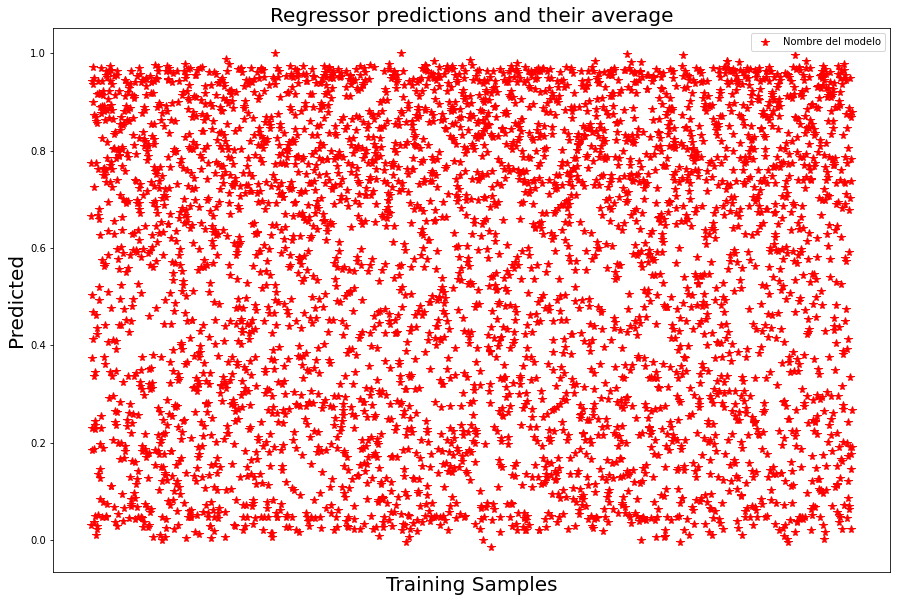

In [90]:
plt.figure(figsize=(15,10))

plt.plot(ereg_pred, 'r*', ms=8, label='Nombre del modelo')

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Predicted', fontsize = 20)
plt.xlabel('Training Samples', fontsize = 20)
plt.legend(loc="best")
plt.title('Regressor predictions and their average', fontsize = 20)

Text(0.5, 1.0, 'AdaBoost Regressor')

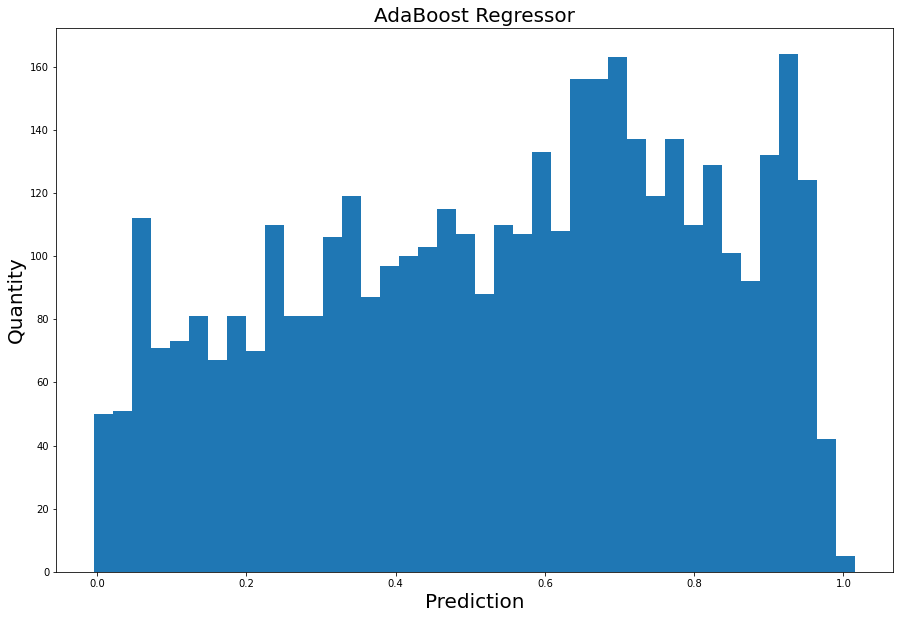

In [91]:
plt.figure(figsize=(15,10))
plt.hist(ada_pred, bins=40)
plt.ylabel('Quantity', fontsize = 20)
plt.xlabel('Prediction', fontsize = 20)
plt.title('AdaBoost Regressor', fontsize = 20)

In [92]:
ada_test = ada.predict(short_test)

# Arma csv de entrega

In [93]:
resultado = pd.DataFrame()
resultado['Opportunity_ID'] = test['Opportunity_ID']
resultado['target'] = ada_test
resultado.sort_values('Opportunity_ID',inplace = True)
resultado = resultado.drop_duplicates('Opportunity_ID',keep = 'last')
resultado.set_index('Opportunity_ID', inplace = True)
resultado.describe()

,target
count,1567.000000
mean,0.522860
std,0.220586
min,0.002844
25%,0.358738
50%,0.532030
75%,0.697668
max,0.976864


In [94]:
csv3 = resultado.to_csv('Ensamble_CB_XG.csv')
files.download('Ensamble_CB_XG.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>